In [1]:
# !pip install -U iminizinc

In [2]:
# Import the necessary libraries
import os
%reload_ext iminizinc
from utils import import_instances, plot_solution, output_solution

<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.5.5, build 273041792
Copyright (C) 2014-2021 Monash University, NICTA, Data61


## Data Import

In [3]:
# Get all instances from text files
instances = import_instances('input/instances/')
print(f'Number of instances: {len(instances)}')

Number of instances: 40


## Constraint Programming

In [4]:
NUMBER = 0

In [5]:
# Get the number of blocks
BLOCKS = []
for n in range(int(instances[NUMBER][1])):
    BLOCKS.append(f'Block {n}')

print(f'Blocks: {BLOCKS}')

Blocks: ['Block 0', 'Block 1', 'Block 2', 'Block 3']


In [6]:
# Get block lengths and heights
BLOCK_WIDTHS = []
BLOCK_HEIGHTS = []

for value in instances[NUMBER][2:]:
    width, height = value.split(' ')
    BLOCK_WIDTHS.append(int(width))
    BLOCK_HEIGHTS.append(int(height))
    
print(f'Block widths: {BLOCK_WIDTHS}')
print(f'Block heights: {BLOCK_HEIGHTS}')

Block widths: [3, 3, 5, 5]
Block heights: [3, 5, 3, 5]


In [7]:
# Get the maximum width and height
MAX_WIDTH = int(instances[NUMBER][0])
MAX_HEIGHT = sum(BLOCK_HEIGHTS)

print(f'Maximum width: {MAX_WIDTH}')
print(f'Maximum height: {MAX_HEIGHT}')

Maximum width: 8
Maximum height: 16


In [8]:
%%minizinc -m bind

include "globals.mzn";

enum BLOCKS;
array[BLOCKS] of int: BLOCK_WIDTHS;
array[BLOCKS] of int: BLOCK_HEIGHTS;

int: MAX_WIDTH;
int: MAX_HEIGHT;

% Constraints to find y-coordinates
array[BLOCKS] of var 0..MAX_HEIGHT: start_y;
var 0..MAX_HEIGHT: end_y;

constraint cumulative(start_y, BLOCK_HEIGHTS, BLOCK_WIDTHS, MAX_WIDTH);

constraint forall(b in BLOCKS)(start_y[b] + BLOCK_HEIGHTS[b] <= end_y);

% Constraints to find x-coordinates
array[BLOCKS] of var 0..MAX_WIDTH: start_x;

constraint cumulative(start_x, BLOCK_WIDTHS, BLOCK_HEIGHTS, end_y);

constraint forall(b in BLOCKS)(start_x[b] + BLOCK_WIDTHS[b] <= MAX_WIDTH);

solve minimize end_y;

In [9]:
# Output
print(f'Minimum height: {end_y}')
print(f'Location x: {start_x}')
print(f'Location y: {start_y}')

Minimum height: 8
Location x: [5, 5, 0, 0]
Location y: [5, 0, 5, 0]


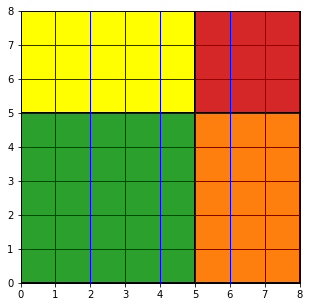

In [10]:
# Plot the solution found
circuits = []
for i in range(len(BLOCKS)):
    circuits.append([BLOCK_WIDTHS[i], BLOCK_HEIGHTS[i], start_x[i], start_y[i]])
    
plot_solution(MAX_WIDTH, end_y, len(BLOCKS), circuits)

## Data Output

In [11]:
# Write the solution to a text file
output_solution('output/cp/', instances, NUMBER, start_x, start_y, end_y)

['8 8', '4', '3 3 5 5', '3 5 5 0', '5 3 0 5', '5 5 0 0']
